In [1]:
import requests
import pandas as pd
import os
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from dotenv import load_dotenv

# Setting pandas to display all columns and rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


# Load API key from .env file
load_dotenv('.env')
api_key = os.getenv('API_KEY')

In [2]:
def extract(api_key):
    """
    Fetch and process air quality measurements from the OpenAQ API.

    Parameters
    ----------
    api_key : str
        API key for authentication with the OpenAQ API.

    Returns
    -------
    df : pandas.DataFrame
        Dataframe containing the fetched measurements.
        
    Raises
    ------
    requests.exceptions.HTTPError
        For HTTP related errors.
    requests.exceptions.ConnectionError
        For connection related errors.
    requests.exceptions.Timeout
        For timeout errors.
    requests.exceptions.RequestException
        For all other request related errors.
    Exception
        If the fetched dataframe is empty.

    """
    
    # API URL
    api_url = "https://api.openaq.org/v2/measurements"
    
    # Define the query parameters to API
    params = {
        "location_id": "380422",
        "parameter": ["pressure", "temperature", "um003", "um025", "um010", "pm10", "um100", "pm1", "um005", "humidity", "um050", "pm25"],
        "limit": 10000,
        "api_key": api_key
    }
    
    try:
        # Make the GET request
        response = requests.get(api_url, params=params)
        
        # Raise exception for HTTP errors
        response.raise_for_status()
        
        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()
            output = pd.json_normalize(data['results'])
            df = pd.DataFrame(output)
            
            # Check if dataframe is empty
            if df.empty:
                raise Exception("Empty df, check API request")
            
            df['date.utc'] = pd.to_datetime(df['date.utc'], errors='coerce') # Convert to datetime
            df['date.local'] = df['date.utc'].dt.tz_convert('America/Los_Angeles') # Covert to PST/PDT time zone
            df['date.local'] = df['date.local'].dt.tz_localize(None) # Convert to timezone-naive
            df = df[df['value'] > 0.0] # Filter values
            
            return df
        
    except requests.exceptions.HTTPError as errh:
        print("Http Error:", errh)
    except requests.exceptions.ConnectionError as errc:
        print("Error Connecting:", errc)
    except requests.exceptions.Timeout as errt:
        print("Timeout Error:", errt)
    except requests.exceptions.RequestException as err:
        print("Error: Something Else", err)
    except Exception as e:
        print(e)

In [3]:
# Call extract function
df = extract(api_key)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8922 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   locationId             8922 non-null   int64              
 1   location               8922 non-null   object             
 2   parameter              8922 non-null   object             
 3   value                  8922 non-null   float64            
 4   unit                   8922 non-null   object             
 5   country                8922 non-null   object             
 6   city                   0 non-null      object             
 7   isMobile               8922 non-null   bool               
 8   isAnalysis             0 non-null      object             
 9   entity                 8922 non-null   object             
 10  sensorType             8922 non-null   object             
 11  date.utc               8922 non-null   datetime64[ns, UTC]
 1

## Available Parameters

In [4]:
# Get locations from API

endpoint = "https://api.openaq.org/v2/parameters"

params = {
    "limit": 1000,
    "api_key": "bca2413f10b586fc8e29e6a7712258baf2d528cfdfc06dcba5bf1cc44e714a9c"
}

# API request
response = requests.get(endpoint, params=params)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    data = response.json()
    output = data['results']
    parameters = pd.DataFrame(output)
else:
    print("Error:", response.status_code)


print(parameters.info())

parameters

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             64 non-null     int64 
 1   name           64 non-null     object
 2   displayName    60 non-null     object
 3   description    64 non-null     object
 4   preferredUnit  64 non-null     object
dtypes: int64(1), object(4)
memory usage: 2.6+ KB
None


,id,name,displayName,description,preferredUnit
0,1,pm10,PM10,Particulate matter less than 10 micrometers in...,µg/m³
1,2,pm25,PM2.5,Particulate matter less than 2.5 micrometers i...,µg/m³
2,3,o3,O₃ mass,Ozone mass concentration,µg/m³
3,4,co,CO mass,Carbon Monoxide mass concentration,µg/m³
4,5,no2,NO₂ mass,Nitrogen Dioxide mass concentration,µg/m³
5,6,so2,SO₂ mass,Sulfur Dioxide mass concentration,µg/m³
6,7,no2,NO₂,Nitrogen Dioxide concentration,ppm
7,8,co,CO,Carbon Monoxide concentration,ppm
8,9,so2,SO₂,Sulfur Dioxide concentration,ppm
9,10,o3,O₃,Ozone concentration,ppm


## EDA

In [5]:
df.head(20)

,locationId,location,parameter,value,unit,country,city,isMobile,isAnalysis,entity,sensorType,date.utc,date.local,coordinates.latitude,coordinates.longitude
0,380422,Tipperary Park,pm25,1.568750,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-18 19:00:00+00:00,2023-10-18 12:00:00,49.208733,-122.9118
1,380422,Tipperary Park,temperature,57.750000,f,CA,None,False,None,Community Organization,low-cost sensor,2023-10-18 19:00:00+00:00,2023-10-18 12:00:00,49.208733,-122.9118
3,380422,Tipperary Park,pm10,1.781250,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-18 19:00:00+00:00,2023-10-18 12:00:00,49.208733,-122.9118
4,380422,Tipperary Park,pm1,0.912500,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-18 19:00:00+00:00,2023-10-18 12:00:00,49.208733,-122.9118
5,380422,Tipperary Park,um003,3.358750,particles/cm³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-18 19:00:00+00:00,2023-10-18 12:00:00,49.208733,-122.9118
6,380422,Tipperary Park,humidity,70.437500,%,CA,None,False,None,Community Organization,low-cost sensor,2023-10-18 19:00:00+00:00,2023-10-18 12:00:00,49.208733,-122.9118
7,380422,Tipperary Park,um005,0.948125,particles/cm³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-18 19:00:00+00:00,2023-10-18 12:00:00,49.208733,-122.9118
8,380422,Tipperary Park,pressure,1010.662500,mb,CA,None,False,None,Community Organization,low-cost sensor,2023-10-18 19:00:00+00:00,2023-10-18 12:00:00,49.208733,-122.9118
10,380422,Tipperary Park,um010,0.115625,particles/cm³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-18 19:00:00+00:00,2023-10-18 12:00:00,49.208733,-122.9118
11,380422,Tipperary Park,um025,0.006250,particles/cm³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-18 19:00:00+00:00,2023-10-18 12:00:00,49.208733,-122.9118


In [6]:
df.columns

Index(['locationId', 'location', 'parameter', 'value', 'unit', 'country',
       'city', 'isMobile', 'isAnalysis', 'entity', 'sensorType', 'date.utc',
       'date.local', 'coordinates.latitude', 'coordinates.longitude'],
      dtype='object')

In [7]:
df.dtypes

locationId                             int64
location                              object
parameter                             object
value                                float64
unit                                  object
country                               object
city                                  object
isMobile                                bool
isAnalysis                            object
entity                                object
sensorType                            object
date.utc                 datetime64[ns, UTC]
date.local                    datetime64[ns]
coordinates.latitude                 float64
coordinates.longitude                float64
dtype: object

In [8]:
df.dtypes

locationId                             int64
location                              object
parameter                             object
value                                float64
unit                                  object
country                               object
city                                  object
isMobile                                bool
isAnalysis                            object
entity                                object
sensorType                            object
date.utc                 datetime64[ns, UTC]
date.local                    datetime64[ns]
coordinates.latitude                 float64
coordinates.longitude                float64
dtype: object

In [9]:
df[df["parameter"] == "pm25"].size

12495

In [10]:
df[df["parameter"] == "pm25"].head()

,locationId,location,parameter,value,unit,country,city,isMobile,isAnalysis,entity,sensorType,date.utc,date.local,coordinates.latitude,coordinates.longitude
0,380422,Tipperary Park,pm25,1.568750,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-18 19:00:00+00:00,2023-10-18 12:00:00,49.208733,-122.9118
23,380422,Tipperary Park,pm25,10.047826,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-18 18:00:00+00:00,2023-10-18 11:00:00,49.208733,-122.9118
25,380422,Tipperary Park,pm25,2.341176,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-18 17:00:00+00:00,2023-10-18 10:00:00,49.208733,-122.9118
41,380422,Tipperary Park,pm25,1.647368,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-18 16:00:00+00:00,2023-10-18 09:00:00,49.208733,-122.9118
56,380422,Tipperary Park,pm25,1.179167,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-18 15:00:00+00:00,2023-10-18 08:00:00,49.208733,-122.9118


In [11]:
df['value'][df["parameter"] == "pm25"].head()

0      1.568750
23    10.047826
25     2.341176
41     1.647368
56     1.179167
Name: value, dtype: float64

In [12]:
df['value'][df["parameter"] == "pm25"].describe()

count    833.000000
mean       8.483046
std        6.501833
min        0.014286
25%        3.641379
50%        6.783333
75%       11.614815
max       33.851852
Name: value, dtype: float64

In [13]:
for par in df['parameter'].unique():
    result = df['value'][df["parameter"] == par].describe()
    nan_values = df['value'][df["parameter"] == par].isna().sum()
    print(par, end='\n')
    print (result)
    print('Number of nan values:', nan_values)
    print('\n')

pm25
count    833.000000
mean       8.483046
std        6.501833
min        0.014286
25%        3.641379
50%        6.783333
75%       11.614815
max       33.851852
Name: value, dtype: float64
Number of nan values: 0


temperature
count    834.000000
mean      63.286400
std        5.865348
min       51.700000
25%       59.000000
50%       62.000000
75%       66.177032
max       89.882353
Name: value, dtype: float64
Number of nan values: 0


pm10
count    833.000000
mean       9.076465
std        6.909831
min        0.052381
25%        4.053846
50%        7.236842
75%       12.453333
max       38.455556
Name: value, dtype: float64
Number of nan values: 0


pm1
count    831.000000
mean       5.734427
std        4.425324
min        0.005263
25%        2.475431
50%        4.740000
75%        7.763462
max       22.470370
Name: value, dtype: float64
Number of nan values: 0


um003
count    833.000000
mean      11.318399
std        7.457166
min        0.935714
25%        5.836667
50%        9

c:\Users\Ale\anaconda3\envs\automate-etl\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\Ale\anaconda3\envs\automate-etl\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\Ale\anaconda3\envs\automate-etl\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\Ale\anaconda3\envs\automate-etl\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\Ale\anaconda3\envs\automate-etl\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\Ale\anaconda3\envs\automate-etl\lib\site-packages\seaborn\axisgrid.py:118: UserWarning

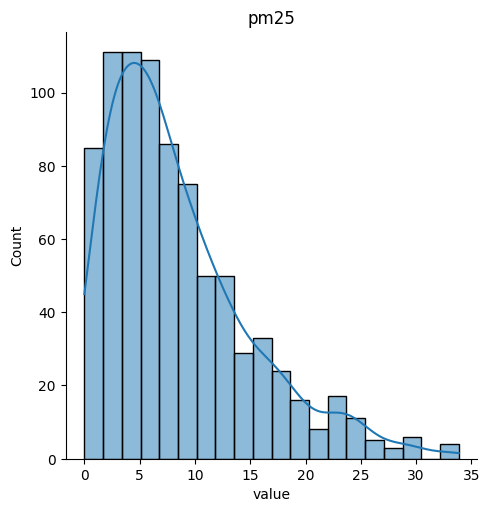

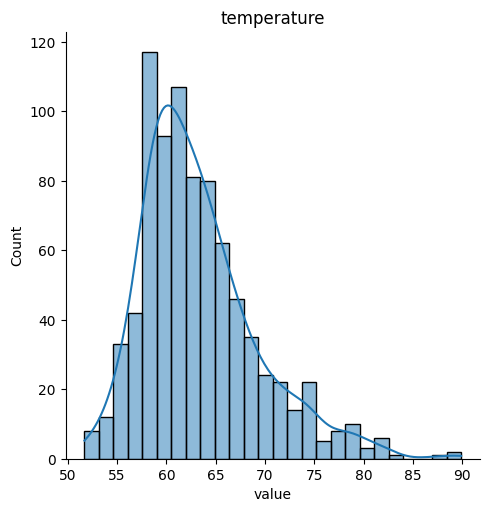

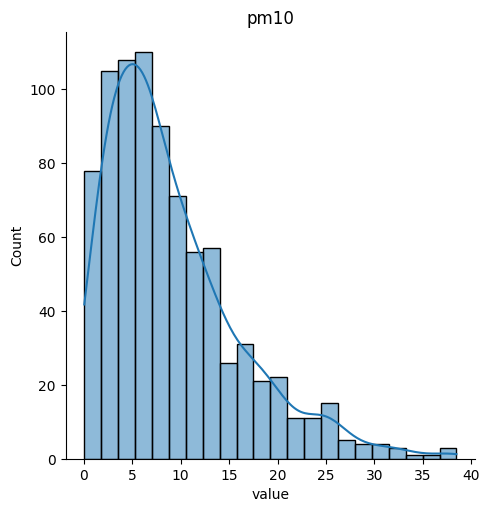

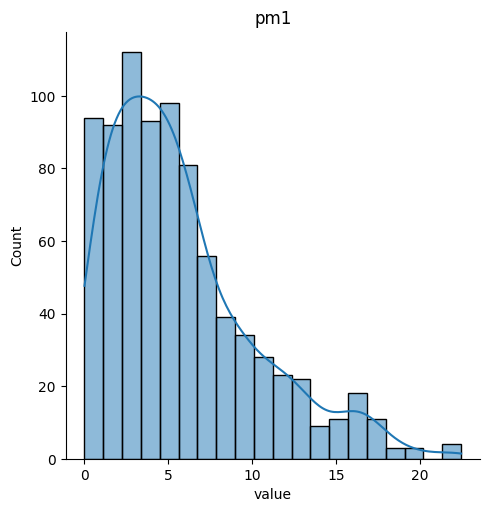

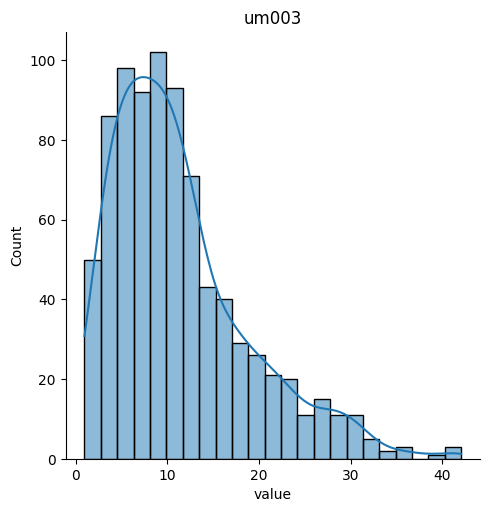

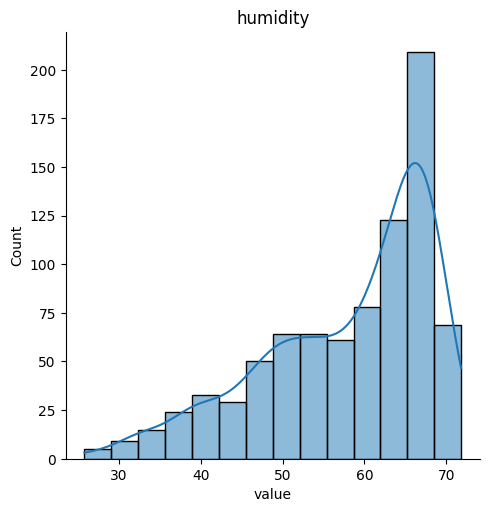

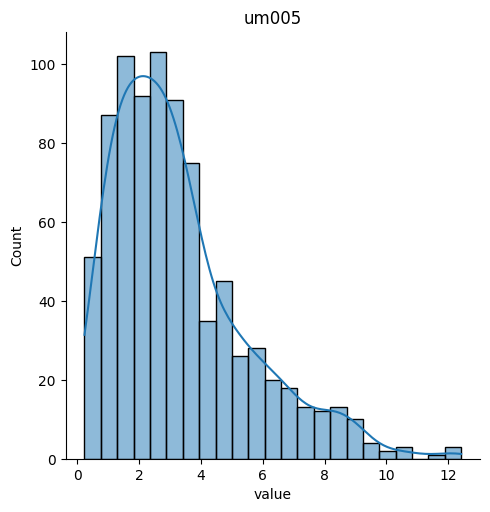

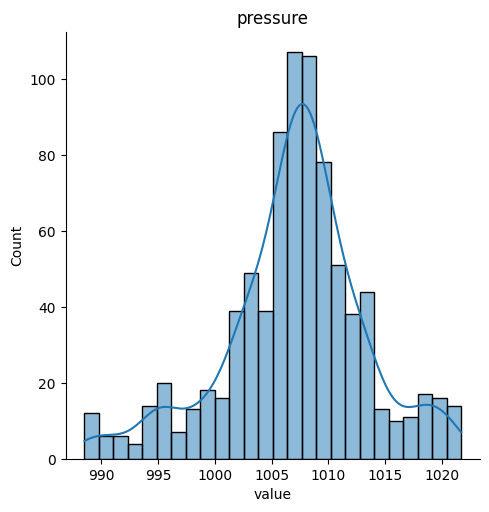

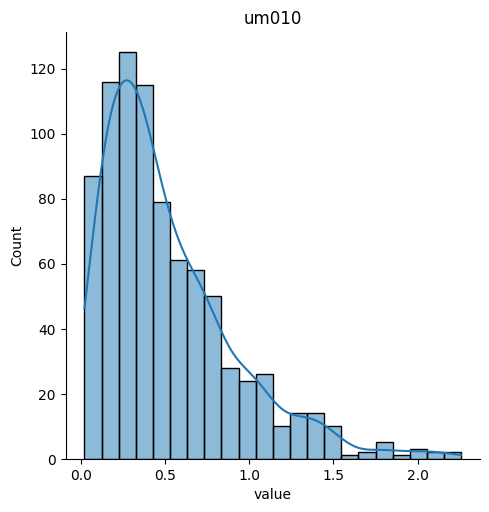

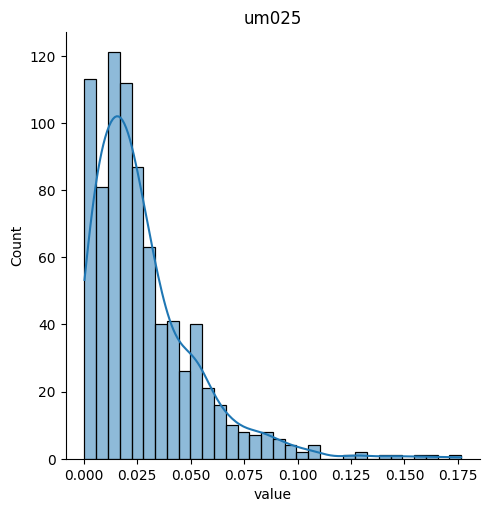

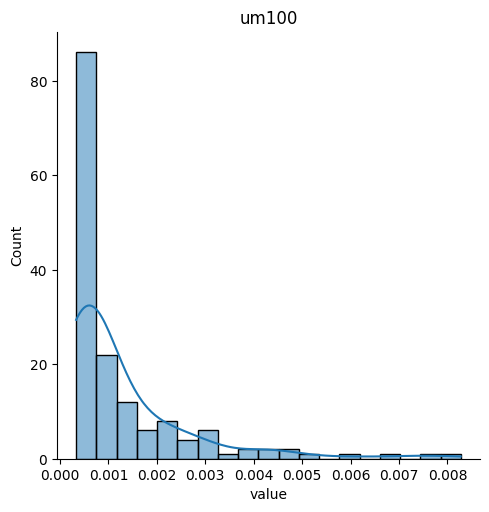

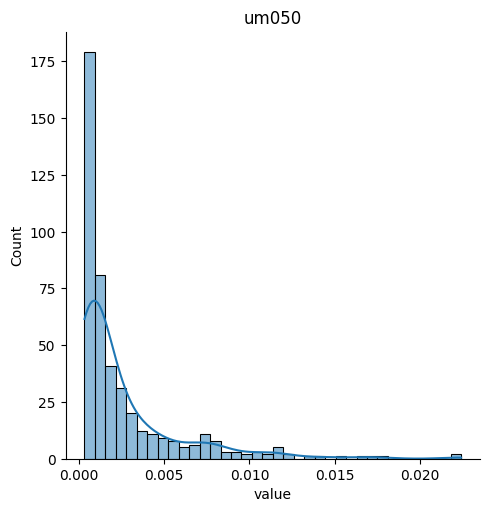

In [14]:
for par in df['parameter'].unique():
    sns.displot(df['value'][df["parameter"] == par], kde=True).set(title=par)

In [15]:
print(df['date.local'].min())
print(df['date.local'].max())

2023-09-13 19:00:00
2023-10-18 12:00:00


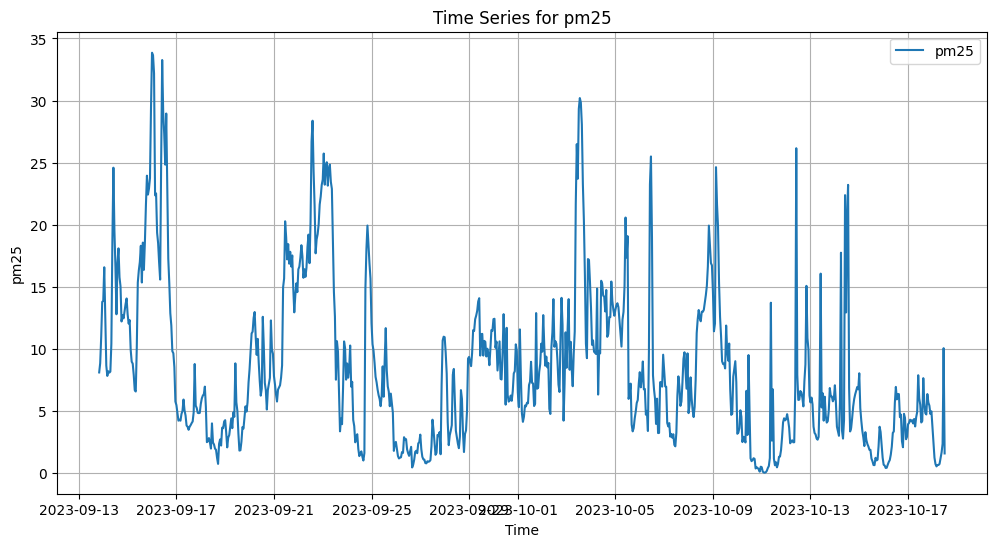

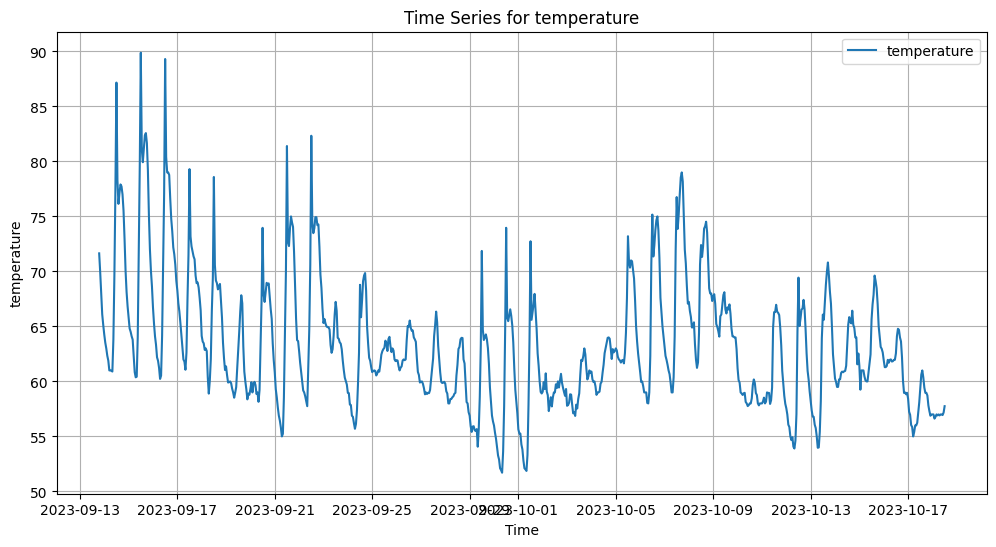

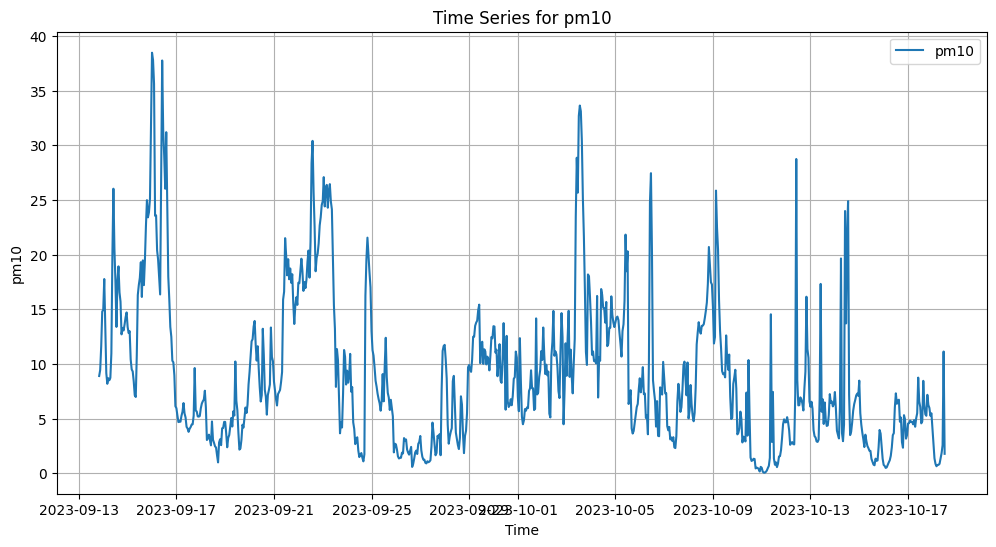

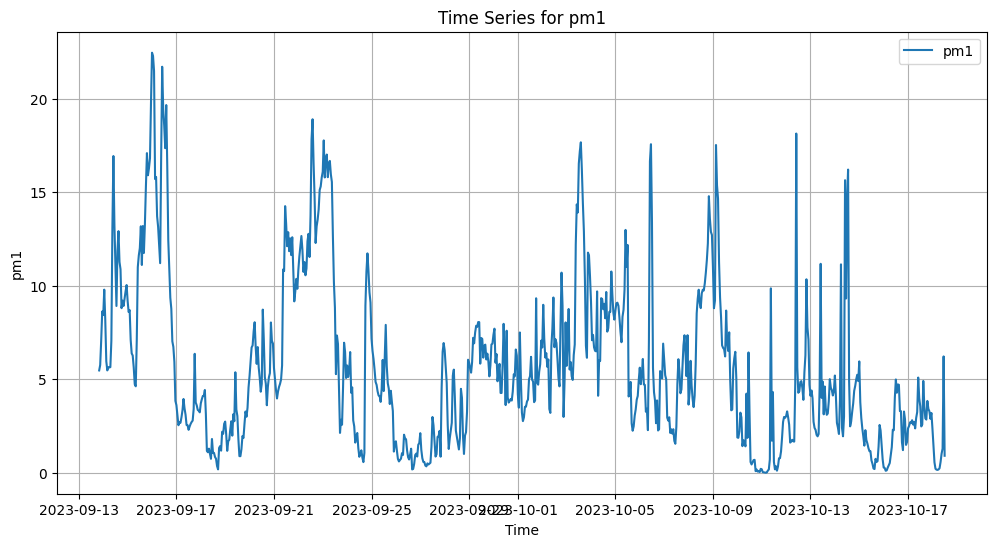

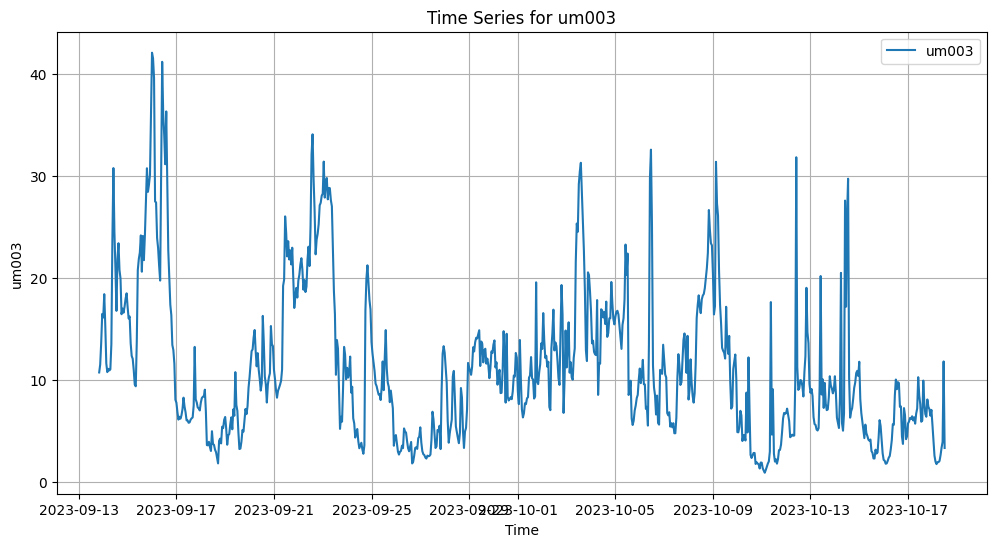

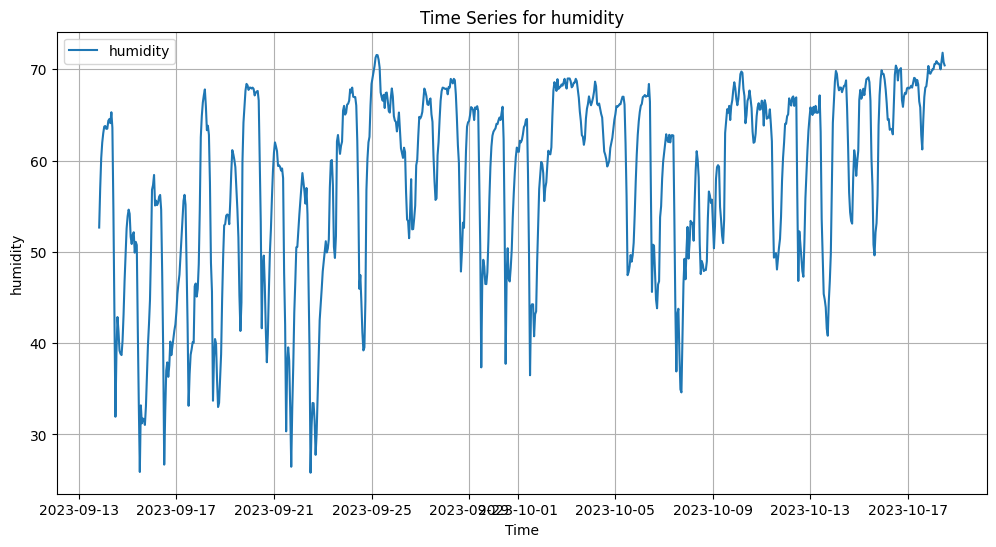

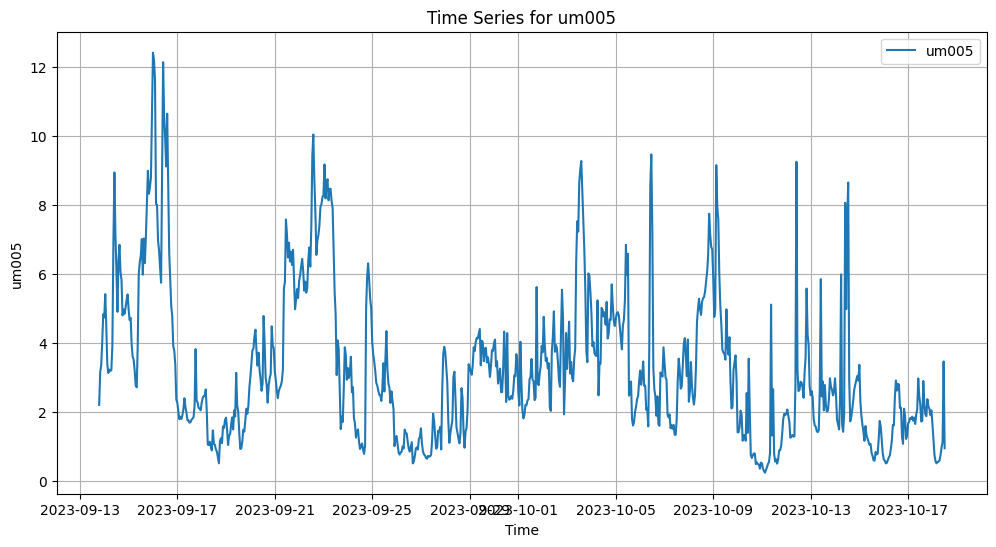

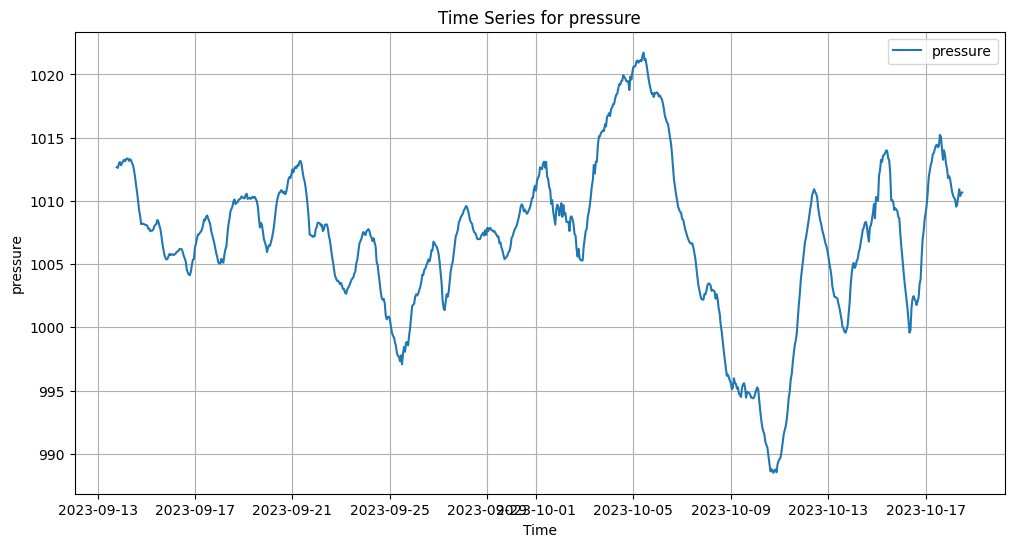

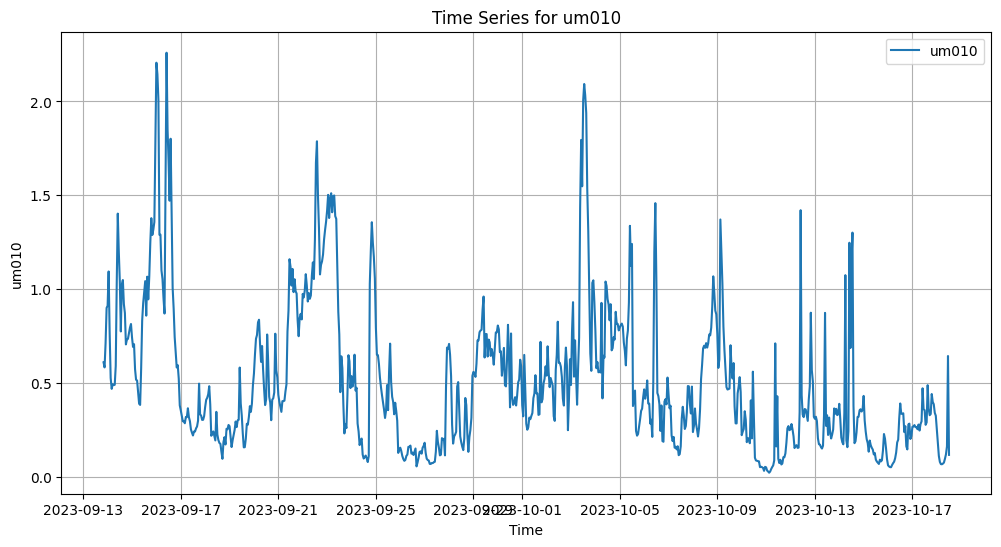

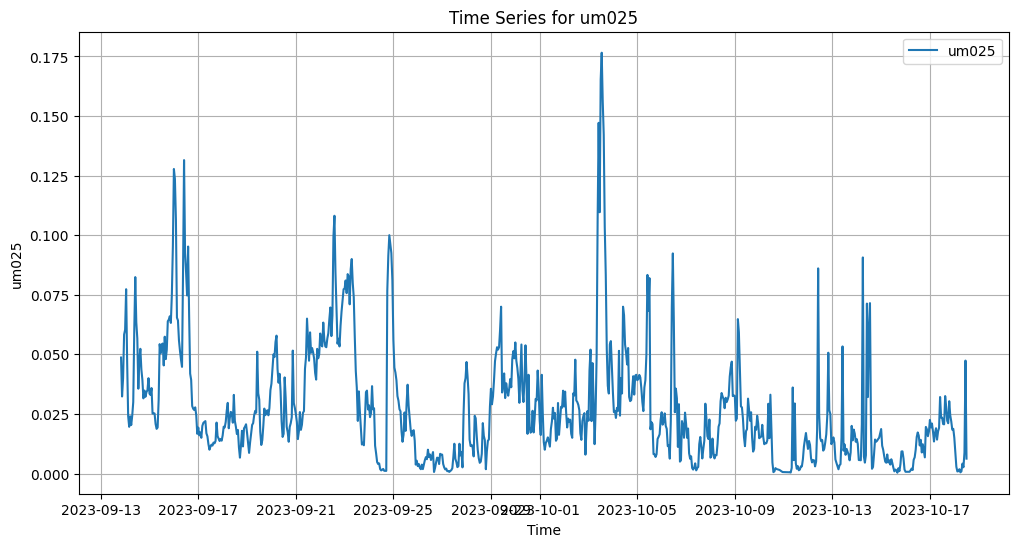

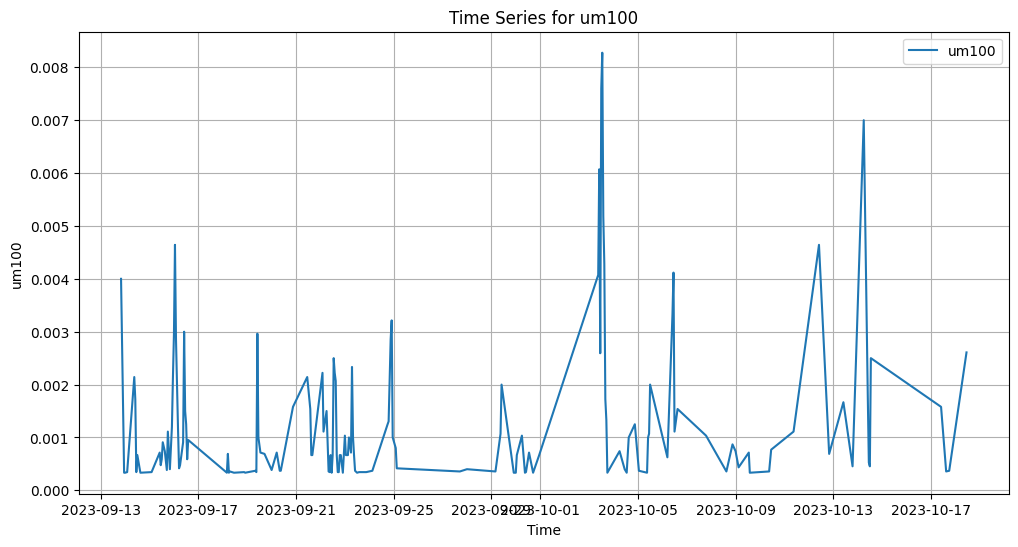

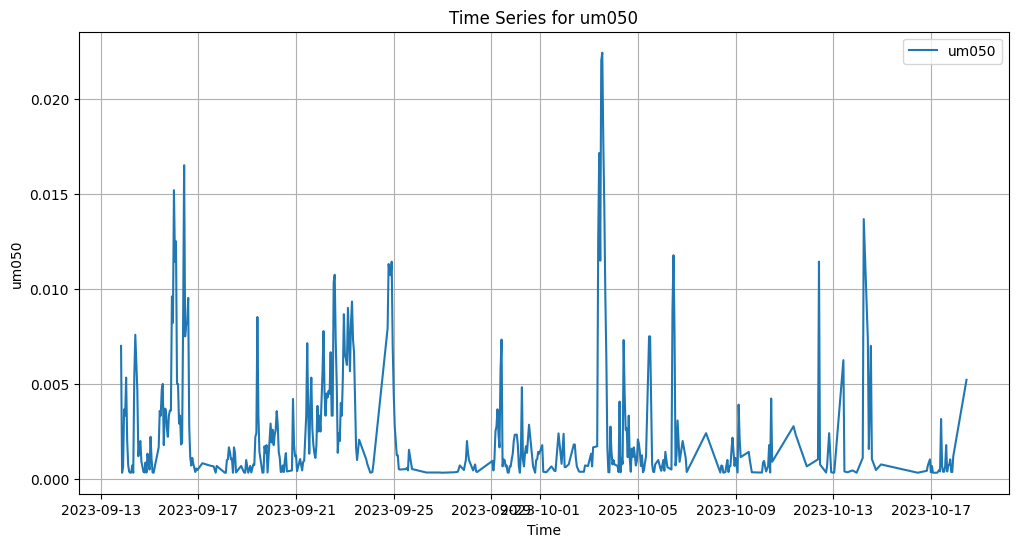

In [16]:
# Loop through unique parameters
for par in df['parameter'].unique():
    plt.figure(figsize=(12, 6))
    
    # Filter the DataFrame for the current parameter
    subset = df[df['parameter'] == par]
    
    # Create the plot
    plt.plot(subset['date.local'], subset['value'], label=par)
    
    plt.xlabel('Time')
    plt.ylabel(par)
    plt.grid(True)
    plt.legend()
    plt.title(f"Time Series for {par}")
    plt.show()

In [17]:
#for parameter in df['parameter'].unique():
#    locals()[parameter] = df[df["parameter"] == parameter]
    
#pm25.head()

In [18]:
pivoted_df = df.pivot_table(index=df['date.local'], columns='parameter', values='value')
pivoted_df.head(20)

parameter,humidity,pm1,pm10,pm25,pressure,temperature,um003,um005,um010,um025,um050,um100
date.local,,,,,,,,,,,,
2023-09-13 19:00:00,NaN,NaN,NaN,NaN,1012.663571,71.642857,NaN,2.203571,NaN,NaN,NaN,NaN
2023-09-13 20:00:00,52.666667,5.476667,8.896667,8.093333,1012.605000,69.933333,10.756000,3.155000,0.609000,0.048667,0.007000,0.004000
2023-09-13 21:00:00,56.966667,5.766667,9.446667,8.840000,1012.931333,68.033333,11.522333,3.354000,0.582000,0.032333,0.000333,NaN
2023-09-13 22:00:00,60.266667,7.103333,11.613333,10.973333,1013.078667,66.100000,13.693333,4.019667,0.711333,0.040000,0.000667,NaN
2023-09-13 23:00:00,61.966667,8.630000,14.783333,13.783333,1012.814333,65.133333,16.488667,4.831667,0.899000,0.058333,0.003667,0.000333
2023-09-14 00:00:00,63.000000,8.440000,14.946667,13.846667,1012.950333,64.266667,16.135667,4.739333,0.910667,0.060333,0.003333,0.000333
2023-09-14 01:00:00,63.733333,9.796667,17.763333,16.566667,1013.090000,63.533333,18.422667,5.415333,1.093333,0.077333,0.005333,NaN
2023-09-14 02:00:00,63.793103,8.165517,13.403448,12.579310,1013.245172,63.000000,15.386897,4.496207,0.768276,0.046897,0.002069,0.000345
2023-09-14 03:00:00,63.481481,5.966667,9.162963,8.644444,1013.125926,62.333333,11.642593,3.386667,0.525556,0.024074,0.000741,NaN


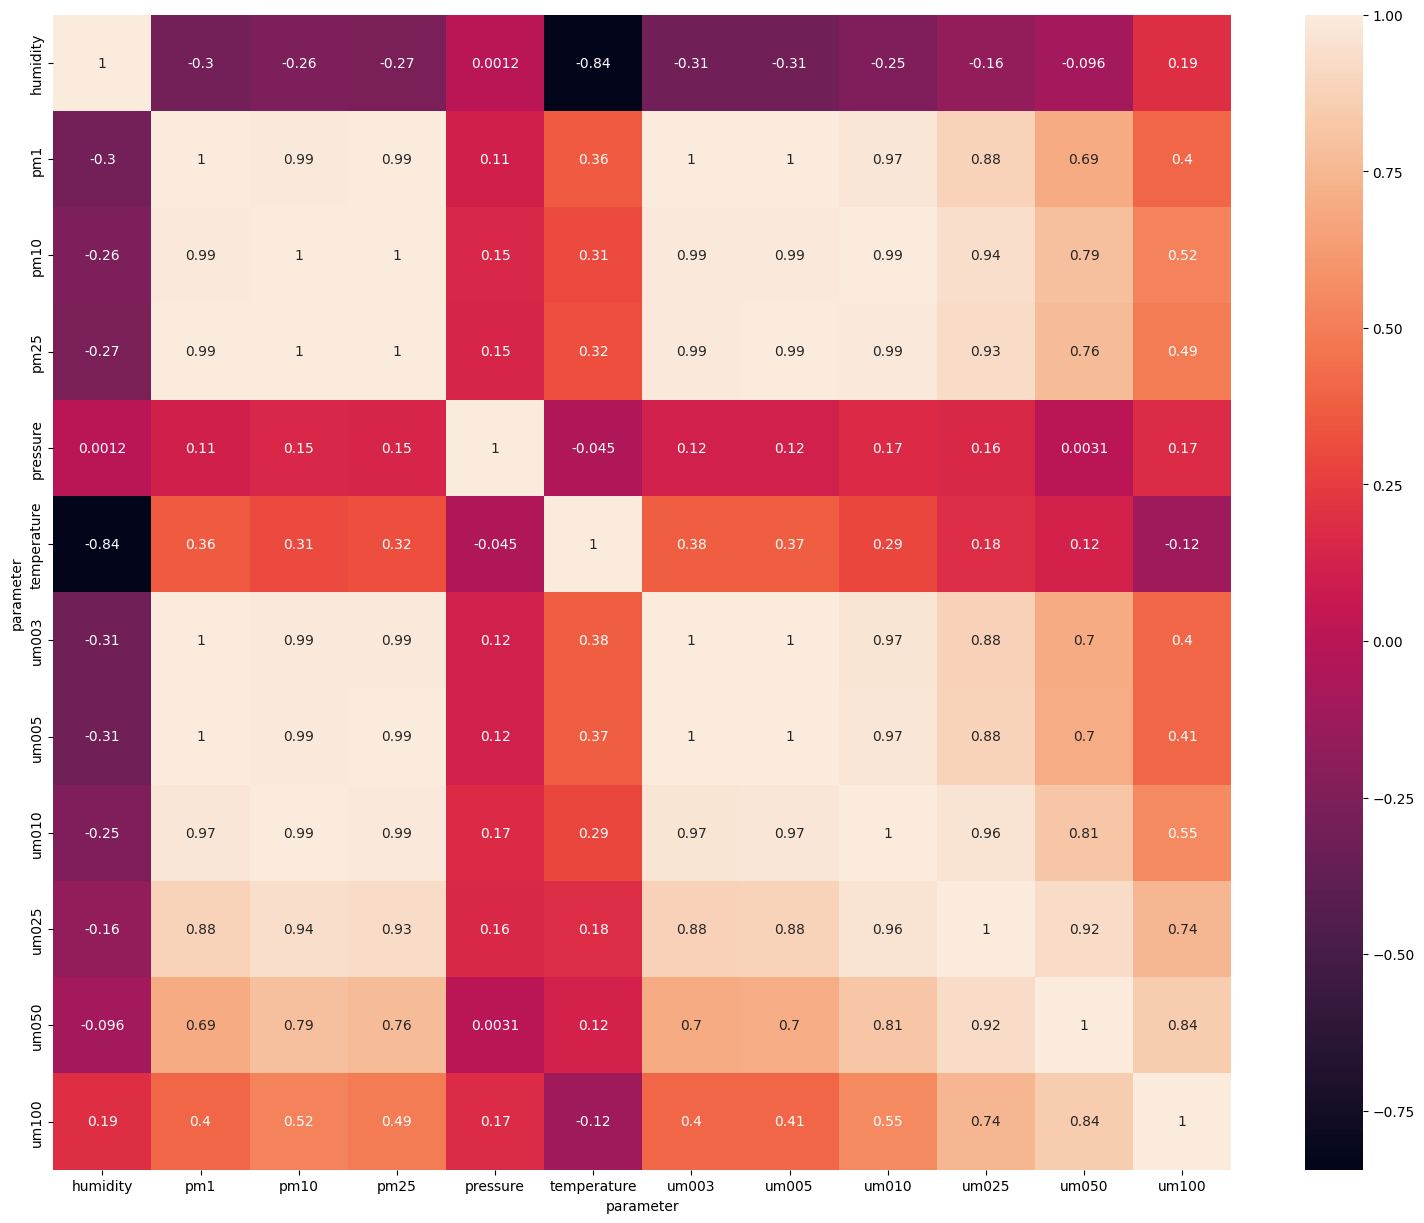

In [19]:
corr_matrix = pivoted_df.corr()
plt.figure(figsize=(19, 15))
sns.heatmap(corr_matrix, annot=True)
plt.show()